이번에는 SimpleRNN보다 복잡한 순환층인 **LSTM**와 **GRU**에 대해 알아보자. SimpleRNN보다 복잡하지만 성능이 뛰어나 순환 신경망에 많이 채택되고 있다.

LSTM은 **Long Short-Term Memory**의 약자이다. 말 그대로 단기 기억을 오래 기억하기 위해 고안되었다. 

LSTM에는 **입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는 구조를 여러 개 가지고 있다**. 이런 계산 결과는 다음 타임스텝에 재사용된다.

먼저 은닉 상태를 만드는 방법을 알아보자. 은닉 상태는 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉 상태를 만든다. 이때 기본 순환층과는 달리 **시그모이드 활성화 함수를 사용**한다. 

LSTM에는 순환되는 상태가 2개이다. 하나는 은닉 상태, 다른 하나는 **'셀 상태(cell state)'**이다. 은닉 상태와 달리 셀 상태는 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값이다.

셀 상태를 계산하는 방법은 다음과 같다. 먼저 **입력과 은닉 상태를 또 다른 가중치에 곱한 다음 시그모이드 함수를 통과시킨다**. 그 다음 이전 타임스텝의 셀 상태와 곱하여 새로운 셀 상태를 만든다. 

여기에 2개의 작은 셀이 더 추가되어 셀 상태를 만드는 데 기여한다. 이전과 마찬가지로 입력과 은닉 상태를 각기 다른 가중치에 곱한 다음, **하나는 시그모이드 함수를 통과시키고 다른 하나는 tanh 함수를 통과**시킨다. 그 다음 두 결과를 곱한 후 이전 셀 상태와 더한다. 이후 만들어진 셀 상태를 tanh 함수를 통과시켜 처음 시그모이드 함수를 통과했던 은닉 상태와 곱하면 최종 은닉 상태가 출력된다.

* 시그모이드 함수는 3번, tanh 함수는 2번 사용한다.

총 3번의 곱셈 계산을 했는데 이를 다음과 같이 부른다.
* 이전 셀 상태와 곱하는 계산: **삭제 게이트(gate)**
* 시그모이드 함수와 tanh 함수를 통과한 두 결과를 곱하는 계산: **입력 게이트**
* 최종 셀 상태를 tanh함수에 통과시키고 시그모이드 함수에 통과 시켰던 은닉 상태와 곱하는 계산: **출력 게이트**

삭제 게이트는 셀 상태에 있는 정보를 제거하는 역할을 하고 입력 게이트는 새로운 정보를 셀 상태에 추가한다. 출력 게이트를 통해 이 셀 상태가 다음 은닉 상태로 출력된다.

먼저 IMDB 리뷰 데이터를 로드하고 훈련 세트와 검증 세트로 나누어보자.

In [ ]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words = 500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size = 0.2, random_state = 42)

17473536/17464789 [==============================] - 0s 0us/step


샘플의 길이를 100으로 맞추자.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen = 100)
val_seq = pad_sequences(val_input, maxlen = 100)

LSTM 셀을 사용한 순환층을 만들어 보자. 케라스에서는 **LSTM 클래스**로 해당 기능을 제공한다.

In [ ]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length = 100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

모델 구조를 출력해보자.

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


단순 신경망의 경우 16 × 8 ＋ 8 × 8 ＋ 8 = 200 개의 파라미터를 가진다. LSTM은 총 4개의 작은 셀이 존재하므로 정확히 4배의 파라미터를 가진다.

모델을 컴파일 하고 훈련해보자. 배치크기는 64, 에프크 횟수는 100으로 지정하자.

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-lstm-model.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history = model.fit(train_seq, train_target, epochs = 100, batch_size = 64, validation_data = (val_seq, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 19s 50ms/step - loss: 0.6921 - accuracy: 0.5324 - val_loss: 0.6907 - val_accuracy: 0.5760
Epoch 2/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6882 - accuracy: 0.6092 - val_loss: 0.6849 - val_accuracy: 0.6328
Epoch 3/100
313/313 [==============================] - 16s 50ms/step - loss: 0.6762 - accuracy: 0.6586 - val_loss: 0.6628 - val_accuracy: 0.6804
Epoch 4/100
313/313 [==============================] - 15s 49ms/step - loss: 0.6165 - accuracy: 0.7063 - val_loss: 0.5774 - val_accuracy: 0.7232
Epoch 5/100
313/313 [==============================] - 15s 47ms/step - loss: 0.5575 - accuracy: 0.7417 - val_loss: 0.5466 - val_accuracy: 0.7422
Epoch 6/100
313/313 [==============================] - 15s 48ms/step - loss: 0.5326 - accuracy: 0.7572 - val_loss: 0.5309 - val_accuracy: 0.7484
Epoch 7/100
313/313 [==============================] - 16s 50ms/step - loss: 0.5126 - accuracy: 0.7674 - val_loss: 0.5109 - val_ac

훈련 손실과 검증 손실을 그려보자.

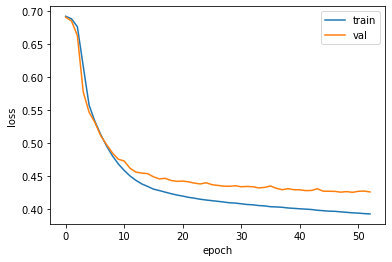

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

기본 순환층보다 LSTM이 과대적합을 잘 억제하면서 훈련을 잘 수행한 것으로 보인다. 하지만 경우에 따라 과대적합을 더 강하게 제어할 필요가 있다.

사실 순환층에도 드롭아웃 기능을 사용할 수 있다. SimpleRNN과 LSTM 클래스 모두 **dropout 매개변수**와 **recurrent_dropout 매개변수**를 가진다. dropout 매개변수는 셀의 입력에 드롭아웃을 지정하고 recurrent_dropout은 순환되는 은닉 상태에 드롭아웃을 적용한다. 기술적 문제로 recurrent_dropout을 사용하면 GPU를 사용하여 모델을 훈련하지 못한다. 따라서 모델의 훈련 속도가 크게 느려진다. 따라서 우리는 dropout만 사용해 보기로 하자.

전체적인 모델 구조는 이전과 동일하며 dropout 매개변수는 0.3으로 지정하자.

In [ ]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length = 100))
model2.add(keras.layers.LSTM(8, dropout = 0.3))
model2.add(keras.layers.Dense(1, activation = 'sigmoid'))

모델을 이전과 동일한 조건으로 훈련해보자.

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model2.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-dropout-model.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history = model2.fit(train_seq, train_target, epochs = 100, batch_size = 64, validation_data = (val_seq, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 18s 51ms/step - loss: 0.6923 - accuracy: 0.5412 - val_loss: 0.6911 - val_accuracy: 0.5948
Epoch 2/100
313/313 [==============================] - 16s 51ms/step - loss: 0.6892 - accuracy: 0.5948 - val_loss: 0.6870 - val_accuracy: 0.6446
Epoch 3/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6807 - accuracy: 0.6377 - val_loss: 0.6720 - val_accuracy: 0.5920
Epoch 4/100
313/313 [==============================] - 15s 49ms/step - loss: 0.6378 - accuracy: 0.6762 - val_loss: 0.6132 - val_accuracy: 0.7212
Epoch 5/100
313/313 [==============================] - 15s 48ms/step - loss: 0.5975 - accuracy: 0.7340 - val_loss: 0.5906 - val_accuracy: 0.7310
Epoch 6/100
313/313 [==============================] - 16s 52ms/step - loss: 0.5765 - accuracy: 0.7490 - val_loss: 0.5693 - val_accuracy: 0.7584
Epoch 7/100
313/313 [==============================] - 16s 50ms/step - loss: 0.5601 - accuracy: 0.7592 - val_loss: 0.5538 - val_ac

검증 손실이 약간 향상되었다. 훈련 손실과 검증 손실 그래프를 그려보자.

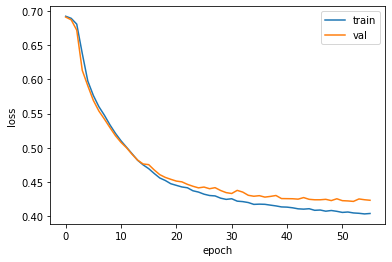

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

이전 그래프보다 훈련 손실과 검증 손실 간의 차이가 좁혀진 것을 확인할 수 있다.

순환층도 이전 밀집층이나 합성곱 층 여러 개를 쌓을 수 있다. 단, 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요하다. 따라서 앞쪽의 순환층은 모든 타임스텝에 대한 은닉 상태를 출력해야한다. 케라스의 순환층에서 모든 타임스텝의 은닉 상태를 출력하려면 마지막을 제외한 다른 모든 순환층에서 **return_sequences 매개변수**를 True로 지정하면된다.

In [ ]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length = 100))
model3.add(keras.layers.LSTM(8, dropout = 0.3, return_sequences = True))
model3.add(keras.layers.LSTM(8, dropout = 0.3))
model3.add(keras.layers.Dense(1, activation = 'sigmoid'))

위와 같이 모델을 만들면 된다. 모델의 구조를 확인해보자.

In [ ]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 8)            800       
_________________________________________________________________
lstm_6 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


타입스텝의 길이가 100이므로 첫 번째 순환층의 은닉 상태도 100개일 것이다. 총 뉴런이 8개이므로 출력의 크기는 (None, 100, 8)이 된다.

앞의 조건과 동일하게 모델을 훈련해보자.

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model3.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history = model3.fit(train_seq, train_target, epochs = 100, batch_size = 64, validation_data = (val_seq, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 52s 147ms/step - loss: 0.6928 - accuracy: 0.5154 - val_loss: 0.6926 - val_accuracy: 0.5198
Epoch 2/100
313/313 [==============================] - 32s 101ms/step - loss: 0.6917 - accuracy: 0.5708 - val_loss: 0.6907 - val_accuracy: 0.5718
Epoch 3/100
313/313 [==============================] - 30s 96ms/step - loss: 0.6864 - accuracy: 0.6075 - val_loss: 0.6795 - val_accuracy: 0.6150
Epoch 4/100
313/313 [==============================] - 31s 100ms/step - loss: 0.6517 - accuracy: 0.6498 - val_loss: 0.6177 - val_accuracy: 0.7048
Epoch 5/100
313/313 [==============================] - 30s 96ms/step - loss: 0.5899 - accuracy: 0.7134 - val_loss: 0.5694 - val_accuracy: 0.7278
Epoch 6/100
313/313 [==============================] - 30s 95ms/step - loss: 0.5564 - accuracy: 0.7326 - val_loss: 0.5420 - val_accuracy: 0.7456
Epoch 7/100
313/313 [==============================] - 30s 96ms/step - loss: 0.5328 - accuracy: 0.7498 - val_loss: 0.5191 - val

일반적으로 순환층을 쌓으면 성능이 높아진다. 하지만 이 예제처럼 그러지 못한 경우도 있다. 손실 그래프를 그려 과대적합이 잘 억제되었는지 확인해보자.

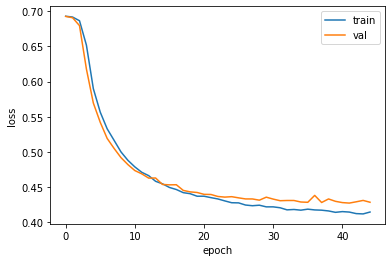

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합을 잘 제어하면서 손실을 최대한 낮춘 것 같다. 지금까지 LSTM 셀을 사용한 훈련과 드롭아웃을 적용해보았고 2개의 층을 쌓은 순환 신경망을 만들어 보았다.

GRU는 **Gated Recurrent Unit**의 약자이다. 이 셀은 LSTM을 간소화한 버전이라고 생각할 수 있다. 이 셀은 LSTM처럼 **셀 상태를 계산하지 않는다**. 

GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 **작은 셀이 3개** 들어있다. **2개는 시그모이드 함수를 사용하고 1개는 tanh 함수를 사용한다.** 첫 번째 시그모이드 함수를 사용하는 셀의 출력은 은닉 상태에 바로 곱해져 삭제 게이트 역할을 수행한다. 이와 동일한 출력을 1에서 뺀 다음 tanh 함수를 거친 셀의 출력에 곱한다. 이는 입력되는 정보를 제어하는 역할을 수행한다. 그리고 두 번째 시그모이드 함수를 사용하는 셀의 출력은 tanh 함수를 사용하는 셀에서 사용할 이전 은닉 상태 정보에 곱해진다. 즉, 은닉 상태의 정보를 제어한다.

GRU 셀은 LSTM보다 가중치가 적어 계산량이 적지만 LSTM 못지않은 성능을 낸다. GRU 셀을 사용한 순환 신경망을 만들어보자. keras.layers 패키지 아래에 **GRU 클래스**를 사용하면 된다.

In [ ]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length = 100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation = 'sigmoid'))

모델의 구조를 살펴보자.

In [ ]:
model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
gru (GRU)                    (None, 8)                 624       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


단순 신경망의 경우 총 200개의 파라미터를 가진다고 이전에 언급했었다. GRU의 경우 작은 셀 3개를 가지므로 3배인 600개를 가져야하지만 624라는 값을 가진다. 왜 이런 값을 출력할까?

텐서플로에서 구현된 GRU 셀의 계산은 앞의 그림과 조금 다르다. GRU 셀의 초기 버전은 지금 설명하는 구조처럼 계산된다.

이전에는 tanh를 사용하는 셀에는 시그모이드 함수가 사용된 셀의 출력과 은닉 상태가 곱해져 입력되었다. 하지만 초기버전에서는 **은닉 상태가 먼저 가중치와 곱해진 다음** 시그모이드를 사용한 셀과 곱해졌다. 이로 인해 은닉 상태에 곱해지는 절편이 별도로 필요하게 된다. 따라서 작은 셀마다 하나씩 절편이 추가되고 8개의 뉴런이 있으므로 3 × 8 = 24개의 모델 파라미터가 추가된다.

이제 모델을 컴파일하고 훈련시켜보자.

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model4.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history = model4.fit(train_seq, train_target, epochs = 100, batch_size = 64, validation_data = (val_seq, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 17s 45ms/step - loss: 0.6928 - accuracy: 0.5182 - val_loss: 0.6925 - val_accuracy: 0.5262
Epoch 2/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6916 - accuracy: 0.5523 - val_loss: 0.6912 - val_accuracy: 0.5430
Epoch 3/100
313/313 [==============================] - 14s 43ms/step - loss: 0.6897 - accuracy: 0.5809 - val_loss: 0.6887 - val_accuracy: 0.5800
Epoch 4/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6864 - accuracy: 0.6008 - val_loss: 0.6849 - val_accuracy: 0.6020
Epoch 5/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6813 - accuracy: 0.6157 - val_loss: 0.6791 - val_accuracy: 0.6112
Epoch 6/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6735 - accuracy: 0.6283 - val_loss: 0.6708 - val_accuracy: 0.6238
Epoch 7/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6621 - accuracy: 0.6404 - val_loss: 0.6580 - val_ac

LSTM과 거의 비슷한 성능을 보여준다. 손실 그래프로 그려서 확인해보자.

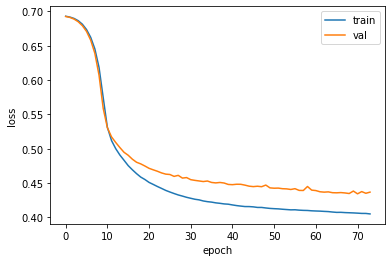

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

드롭아웃을 사용하지 않았기 때문에 이전보다 훈련 손실과 검증 손실 사이에 차이가 있지만 훈련 과정이 잘 수렴되고 있는 것을 알 수 있다.

모든 실습을 마쳤으니 2개의 순환층을 쌓은 모델을 다시 로드하여 성능을 확인해보자.

In [ ]:
test_seq = pad_sequences(test_input, maxlen = 100)
rnn_model = keras.models.load_model('best-2rnn-model.h5')
rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 6s 8ms/step - loss: 0.4284 - accuracy: 0.8015


[0.42841240763664246, 0.8014799952507019]

드롭아웃을 적용하여 과대적합을 잘 억제했기 때문에 테스트 세트의 성능이 검증 세트와 크게 차이나지 않았다.

# 정리

핵심 포인트
* LSTM: **타임스텝이 긴 데이터를 효과적으로 학습하기 위해 고안된 순환층**이다. 입력 게이트, 삭제 게이트, 출력 게이트 역할을 하는 작은 셀이 포함되어 있다.
* 셀 상태: **LSTM이 은닉 상태 외에 출력하는 상태**이다. 셀 상태는 다음 층으로 전달되지 않고 현재 셀에서만 순환된다.
* GRU: **LSTM 셀의 간소화 버전**으로 생각할 수 있지만 LSTM 못지않은 성능을 낸다.

핵심 패키지와 함수

TensorFlow
* LSTM: **LSTM 셀을 사용한 순환층 클래스**이다. 첫 번째 매개변수에 뉴런의 개수를 지정한다. dropout 매개변수에서 입력에 대한 드롭아웃 비율을 지정할 수 있다. return_sequences 매개변수에서 모든 타임스텝의 은닉 상태를 출력할지 결정한다. 기본값은 False이다.
* GRU: **GRU 셀을 사용한 순환층 클래스**이다. 첫 번째 매개변수에 뉴런의 개수를 지정한다. dropout 매개변수에서 입력에 대한 드롭아웃 비율을 지정할 수 있다. return_sequences 매개변수에서 모든 타임스텝의 은닉 상태를 출력할지 결정한다. 기본값은 False이다.